### 1. Introduction - Right Whale Recognition (Image Recognition/Classification)

With fewer than 500 North Atlantic right whales left in the world's oceans, knowing the health and status of each whale is integral to the efforts of researchers working to protect the species from extinction.

Currently, only a handful of very experienced researchers can identify individual whales on sight while out on the water. For the majority of researchers, identifying individual whales takes time, making it difficult to effectively target whales for biological samples, acoustic recordings, and necessary health assessments.

<div style="width:100%;text-align: center;"><img src="https://storage.googleapis.com/kaggle-competitions/kaggle/4521/media/ChristinKhan_RightWhaleMomCalf_640.png"></div>
          
To track and monitor the population, right whales are photographed during aerial surveys and then manually matched to an online photo-identification catalog. Customized software has been developed to aid in this process (DIGITS), but this still relies on a manual inspection of the potential comparisons, and there is a lag time for those images to be incorporated into the database. The current identification process is extremely time consuming and requires special training. This constrains marine biologists, who work under tight deadlines with limited budgets.

This competition challenges you to automate the right whale recognition process using a dataset of aerial photographs of individual whales. Automating the identification of right whales would allow researchers to better focus on their conservation efforts. Recognizing a whale in real-time would also give researchers on the water access to potentially life-saving historical health and entanglement records as they struggle to free a whale that has been accidentally caught up in fishing gear.

**Evaluation**

Submissions are evaluated using the multi-class logarithmic loss. Each image has been labeled with one true class. For each image, you must submit a set of predicted probabilities (one for every whale - see https://www.kaggle.com/competitions/noaa-right-whale-recognition/overview/evaluation for the formula).

The submitted probabilities for a given image are not required to sum to one because they are rescaled prior to being scored (each row is divided by the row sum). In order to avoid the extremes of the log function, predicted probabilities are replaced with \\(max(min(p,1-10^{-15}),10^{-15})\\).

### 2. Import Libraries

A smorgasbord of libraries based on different notebooks I was inspired from.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/noaa-right-whale-recognition/sample_submission.csv
/kaggle/input/noaa-right-whale-recognition/w_7489.jpg.zip
/kaggle/input/noaa-right-whale-recognition/train.csv.zip
/kaggle/input/noaa-right-whale-recognition/sample_submission.csv.zip
/kaggle/input/noaa-right-whale-recognition/imgs.zip
/kaggle/input/noaa-right-whale-recognition/train.csv
/kaggle/input/noaa-right-whale-recognition/w_7489.jpg
/kaggle/input/noaa-right-whale-recognition/imgs_subset.zip


In [2]:
# Importing all necessary libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import tqdm
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import matplotlib.image as mimage
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from tensorflow.keras.utils import img_to_array
from IPython.display import FileLink
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
import random
from zipfile import ZipFile

### 3. Upload Datasets

df_train will be the training/validation images, df_test will be the testing images (based on the sample_submission dataframe)

In [4]:
df_train = pd.read_csv('/kaggle/input/noaa-right-whale-recognition/train.csv')
df_test = pd.read_csv('/kaggle/input/noaa-right-whale-recognition/sample_submission.csv')

### 4. Exploratory Data Analysis

In [5]:
df_train.drop(df_train[df_train['Image'] == 'w_7489.jpg'].index, inplace = True)

* w_7489.jpg was not present in the imgs folder.

In [6]:
df_train.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4543 entries, 0 to 4543
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Image    4543 non-null   object
 1   whaleID  4543 non-null   object
dtypes: object(2)
memory usage: 106.5+ KB


* 4543 different images in the training dataset.

In [8]:
df_test.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
0,w_1947.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,w_11096.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,w_10973.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,w_10442.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,w_10606.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Columns: 448 entries, Image to whale_99573
dtypes: int64(447), object(1)
memory usage: 23.7+ MB


* 6925 test images; the dataframe is different from the training dataframe in that it one-hot encodes the different whales (example = whale_00195 is its own column, while it would have been in the singular whaleID column in the dataset). Also, 448 entries = 448 different whales pictured.

In [10]:
'w_1947.jpg' in df_train["Image"].values

False

* The 'False' above illustrates that the test pictures are not present in the training dataset.

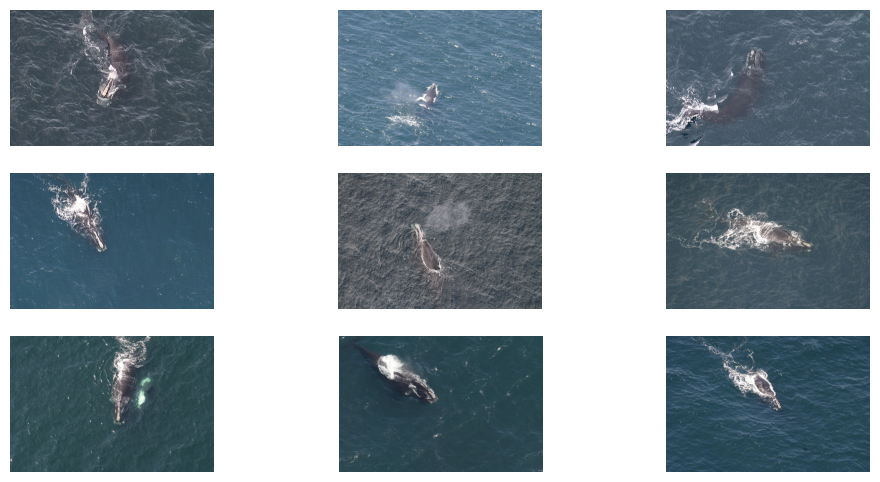

In [11]:
path_im = '/kaggle/input/noaa-right-whale-recognition/imgs.zip'
with ZipFile(path_im, 'r') as zip:
    files = zip.namelist()
    random_files = random.sample(files, 9)
    images = []
    for file in random_files:
        with zip.open(file) as img_file:
            img = Image.open(img_file)
            images.append(np.array(img))
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

* A few random images...some appear much more visible than others to start. Various colors of the water (different gradations of blue and gray).

(array([79., 47., 59., 75., 37., 39., 45., 28., 16.,  8.,  5.,  3.,  3.,
         1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ,
        26.3, 28.6, 30.9, 33.2, 35.5, 37.8, 40.1, 42.4, 44.7, 47. ]),
 <BarContainer object of 20 artists>)

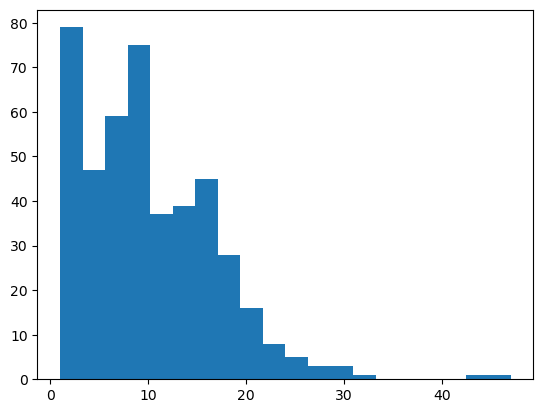

In [28]:
plt.hist(df_train['whaleID'].value_counts(), bins=20)

* Here we see most of the unique whales present in the training dataframe show up between 0 and 20 times, with some definite outliers showing up 30 times or more.

Text(0.5, 1.0, 'Aspect Ratio of Images')

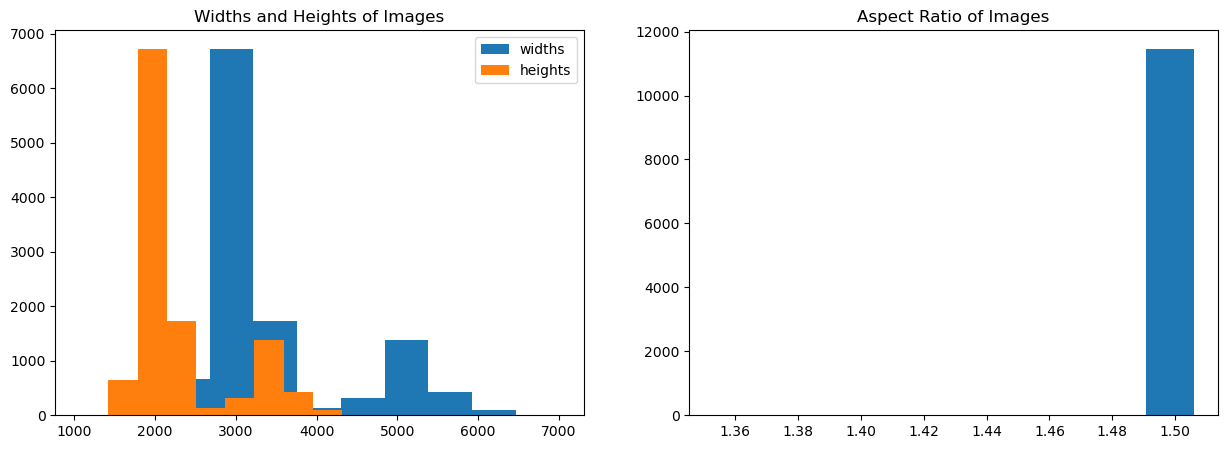

In [11]:
path_im = '/kaggle/input/noaa-right-whale-recognition/imgs.zip'
width = []
height = []
aspect_ratio = []
with ZipFile(path_im, 'r') as zip:
    files = zip.namelist()
    files = list(files)
    del files[0:2]
    for file in files:
        with zip.open(file) as img_file:
            img = Image.open(img_file)
            width.append(img.width)
            height.append(img.height)
            aspect_ratio.append(img.width/img.height)
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(width, label='widths')
plt.hist(height, label='heights')
plt.title('Widths and Heights of Images')
plt.legend()
plt.subplot(1,2,2)
plt.hist(aspect_ratio, range=(min(aspect_ratio), max(aspect_ratio)), bins=10)
plt.title('Aspect Ratio of Images')

* From these illustrations, it is clear most of the images typically have a height of around 2000 and a width of 3000; similarly, the aspect ratio of the total images of the whales is primarily 1.5, which is said to be a natural width to height ratio and does not need to be adjusted in a material way.

In [28]:
#empty matrix is returned on error...if not all files are readable
print(min(width))
print(min(height))
print('\n')
print(len(width))
print(len(height))
print('\n')
print(None in width)
print(None in height)

1590
1059


11468
11468


False
False


* Verification that we measured all of the image data (training and testing combined) in our height/width/aspect ratio analysis.

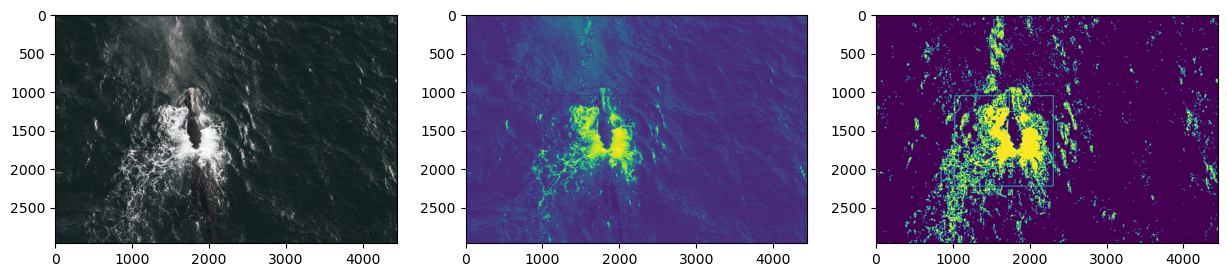

In [35]:
path_im = '/kaggle/input/noaa-right-whale-recognition/imgs.zip'
with ZipFile(path_im, 'r') as zip:
    files = zip.namelist()
    random_files = random.sample(files, 1)
    images = []
    for file in random_files:
        with zip.open(file) as img_file:
            original_img = Image.open(img_file)
            gray = cv2.cvtColor(np.array(original_img), cv2.COLOR_BGR2GRAY)
            blur_gray = cv2.blur(gray, (3,3))
            # threshold
            thresh = cv2.threshold(blur_gray,128,255,cv2.THRESH_BINARY)[1]

            # get contours
            result = original_img.copy()
            contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = contours[0] if len(contours) == 2 else contours[1]
            for cntr in contours:
                x,y,w,h = cv2.boundingRect(cntr)
                cv2.rectangle(gray, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.rectangle(thresh, (x, y), (x+w, y+h), (255, 0, 0), 5)
            
            # show thresh and result
            fig = plt.figure(figsize=(15,5))
            plt.subplot(1,3,1)
            plt.imshow(result)
            plt.subplot(1,3,2)
            plt.imshow(gray)
            plt.subplot(1,3,3)                  
            plt.imshow(thresh)

* Above far left is an example of an untampered image from the dataset, and both images to its right illustrated with bounding boxes. This is an example of a fairly successful bounding box process; from experimentation, a lot of the images have too many contours and too many unfocused bounding boxes as a result, or the bounding box method is entirely unable to notice the whale due to it being primarily submersed underwater anyway. As a result, we will opt to not crop the whale images.

### 5. Data Pre-processing

In [6]:
df_train = pd.get_dummies(df_train, columns = ['whaleID'])
df_train.rename(columns=lambda x: x[8:] if x != 'Image' else x, inplace=True)

* Let's make the training dataframe look similar to the testing dataset; for training purposes, we will need them to be similar, and to train on the same testing variables. Take a look directly below; the training dataframe is now set up similarly to the testing dataframe.

In [7]:
df_train.head()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
0,w_7812.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,w_4598.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,w_3828.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,w_8734.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,w_3251.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [8]:
import os

os.makedirs('/kaggle/temp/training_imgs/')
os.makedirs('/kaggle/temp/testing_imgs/')

* Make temporary folders where we can separate the training images from the testing data as their data are imported from the main zipped file.

In [9]:
train_img_list = df_train["Image"].tolist()
test_img_list = df_test["Image"].tolist()

* Create a list of the names of images in both the training and the testing (submission) file. Below, we will get the images in their proper folders.

In [10]:
import zipfile

count = 0

with zipfile.ZipFile('/kaggle/input/noaa-right-whale-recognition/imgs.zip', 'r') as zip_ref:
    listOfFileNames = zip_ref.namelist() #Get a list of the images in the images file
    for filename in listOfFileNames:
        converted_filename = filename.replace('imgs/','')
        if converted_filename in train_img_list: #if the image is also an image in the training dataset
            zip_ref.extract(filename, path='/kaggle/temp/training_imgs/') #send the image to the training folder
            count += 1
        else: #if it's not in the training dataset
            continue #keep the loop going; don't add it to the training folder      
print(count, "images now in the training file.")

4543 images now in the training file.


In [11]:
count = 0

with zipfile.ZipFile('/kaggle/input/noaa-right-whale-recognition/imgs.zip', 'r') as zip_ref:
    listOfFileNames = zip_ref.namelist() #Get a list of the images in the images file
    for filename in listOfFileNames:
        converted_filename = filename.replace('imgs/','')
        if converted_filename in test_img_list: #if the image is also an image in the testing dataset
            zip_ref.extract(filename, path='/kaggle/temp/testing_imgs/') #send the image to the testing folder
            count += 1
        else: #if it's not in the testing dataset
            continue #keep the loop going; don't add it to the testing folder
            
print(count, "images now in the training file.")

6925 images now in the training file.


* The proper images are in the proper folders. Now let's create the train and test data.

In [12]:
train_path="/kaggle/temp/training_imgs/"
test_path="/kaggle/temp/testing_imgs/"

x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        #print(img_arr)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

* We take the numerical array data from the picture and we resize the picture to 224x224 (for training and testing) for uniformity and speed purposes; then we add the updated image data to our training input variable x_train. We do the same for our testing input data, which is essentially ta resized version of the untampered image like we illustrated above.

In [13]:
x_test=[]

for folder in os.listdir(test_path):
    
    sub_path=test_path+"/"+folder
    
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

* Testing inputs should be added to the x_test variable.

In [14]:
train_x=np.array(x_train, dtype='float32')
test_x=np.array(x_test, dtype='float32')

* We convert the input variables from a list to a numpy array, as it is the data type models typically train and test on. The next two cells normalize the arrays. 

In [15]:
for i in range(len(train_x)):
    train_x[i] = train_x[i]/255

In [16]:
for i in range(len(test_x)):
    test_x[i] = test_x[i]/255

* Below we use Keras ImageDatagenerators, which allow us to implement data augmentation to our training/testing variables (images), whether it be rotation of the images, adjusting height or width of the images, zooming in, or more. See below:

In [17]:
train_generator = ImageDataGenerator(rotation_range=8, width_shift_range=0.1, 
                                     height_shift_range=0.1,
                                     zoom_range=0.1,validation_split=0.1) #rescale=1/255.0
test_generator = ImageDataGenerator() #rescale=1/255.0
#good here

In [18]:
train_generator.fit(train_x)

* Above we fit the training variables on the image data generator, which applies the arguments to the images to be trained on.

In [19]:
train_y = df_train[[column for column in df_train.columns if column != 'Image']].values

* Above we just create the independent training variable which is to provide us results. Next we will create a basic neural network model.

### 6. Create the Model

In [20]:
class_names = df_test.columns[1:]
class_names_labels = {i:class_name for i, class_name in enumerate(class_names)}
NUM_CLASSES = len(class_names)
IMAGE_SIZE = (224, 224)

model = Sequential([
    Conv2D(128, kernel_size=5, input_shape = (224, 224, 3),activation="relu"),
    MaxPool2D(2),
    BatchNormalization(),
    Conv2D(64, kernel_size=3, activation="relu"),
    MaxPool2D(2),
    BatchNormalization(),
    Conv2D(32, kernel_size=3, activation="relu"),
    MaxPool2D(2),
    BatchNormalization(),
    Conv2D(16, kernel_size=3, activation="relu"),
    MaxPool2D(2),
    BatchNormalization(),
    Flatten(),
    Dense(4096, activation="relu"),
    Dropout(0.25),
    Dense(NUM_CLASSES, activation="softmax")
])

* Basic neural network is created above for rudimentary analysis purposes.

In [21]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

* Above we compile the model, which takes the model as input and generates code for deep learning hardware as an output/result.

In [22]:
MCP = ModelCheckpoint('model.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=4,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

* MCP = Saves the model weights

* ES = Stops training when loss is no longer improving

* RLP = Reduces learning rate of a patient model if not seeing improvement

We will include these all as callbacks in our model; now let's run it and see what we get.

### 7. Run the Model

In [23]:
#epochs=1000
history = model.fit(
  train_generator.flow(train_x, train_y, batch_size=32, subset="training"),
  validation_data=train_generator.flow(train_x, train_y, batch_size=16, subset="validation"),
  epochs=10,
  callbacks=[MCP, ES, RLP],
  batch_size=128,shuffle=True)

Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 8.1080 - accuracy: 0.0027
Epoch 1: val_accuracy improved from -inf to 0.00220, saving model to model.h5
128/128 [==============================] - 67s 418ms/step - loss: 8.1080 - accuracy: 0.0027 - val_loss: 6.6807 - val_accuracy: 0.0022 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 6.5075 - accuracy: 0.0100
Epoch 2: val_accuracy improved from 0.00220 to 0.00441, saving model to model.h5
128/128 [==============================] - 51s 398ms/step - loss: 6.5075 - accuracy: 0.0100 - val_loss: 6.2298 - val_accuracy: 0.0044 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 5.9912 - accuracy: 0.0210
Epoch 3: val_accuracy did not improve from 0.00441
128/128 [==============================] - 52s 410ms/step - loss: 5.9912 - accuracy: 0.0210 - val_loss: 6.3651 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - ETA

* Only get through 8 epochs likely due to early stopping, etc. Definitely training improvement as expected, but not much validation improvement.

In [24]:
test_gnr = test_generator.flow(test_x)
predict_x=model.predict(test_gnr) 
classes_x=np.argmax(predict_x,axis=1)

217/217 [==============================] - 6s 25ms/step


* We add image data generator arguments to the training input images, and we predict the whales on the test images in one-hot encoded form. Let's submit.

### 8. Model Submission

We want to add the predicted probabilities of each of the whales in the dataset being the one pictured in the picture, which is in predict_x. We will input this data into the test dataframe and we will have our submission set up!

In [25]:
df_test[[column for column in df_test.columns if column != 'Image']] = predict_x.tolist()
df_test.tail()

,Image,whale_00195,whale_00442,whale_02411,whale_02608,whale_02839,whale_03103,whale_03227,whale_03623,whale_03728,...,whale_98618,whale_98633,whale_98645,whale_98746,whale_98939,whale_98996,whale_99243,whale_99326,whale_99558,whale_99573
6920,w_4867.jpg,0.003325,0.001741,0.008490,0.000781,0.000299,0.001120,0.002359,0.002164,0.000926,...,0.002512,0.002809,0.001824,0.007854,0.002481,0.001506,0.004245,0.000381,0.003104,0.003499
6921,w_5230.jpg,0.003147,0.000382,0.003101,0.003535,0.000388,0.000240,0.002518,0.002136,0.000931,...,0.006755,0.001607,0.002553,0.006362,0.000665,0.000544,0.001609,0.002913,0.002341,0.002936
6922,w_5278.jpg,0.005190,0.000708,0.005216,0.000620,0.000046,0.001247,0.002464,0.001865,0.000691,...,0.002865,0.003224,0.001491,0.005892,0.002323,0.000511,0.004004,0.000100,0.002934,0.004718
6923,w_9218.jpg,0.004510,0.000484,0.005727,0.002046,0.000035,0.000128,0.003476,0.000787,0.000896,...,0.003636,0.001778,0.003544,0.006006,0.000797,0.000141,0.000167,0.003077,0.003715,0.001898
6924,w_9316.jpg,0.003333,0.002237,0.005220,0.000710,0.000216,0.001194,0.002229,0.003451,0.001341,...,0.002166,0.003114,0.001768,0.004845,0.001603,0.001415,0.004736,0.000709,0.002632,0.003799


In [26]:
df_test.to_csv("submission.csv",index=False)

* **Best score of 6.09 upon submission is around 180 out of 320 participants as of 7/17/2023. Where improvements could be made:**

    * Different overall neural network structure
    
    * Tried better to crop the images/use bounding boxes/update the images more